# Discrete Cosine Transform for the Analysis of Essential Tremor, extracted features

## Purpose

It has proven to be very hard to reproduce the results from [Discrete Cosine Transform for the Analysis of Essential Tremor](https://www.frontiersin.org/articles/10.3389/fphys.2018.01947/full)

I have implemented Discrete Cosine Transformation and the features described in the paper above. The features have been extracted from raw WACOM dataset and saved as HDF5 file to facilitate the reproducibility of this notebook. 

Experiment implementation from paper publication was done in Matlab. This experiment source code was implemented in python and the results and source code is public and open:
https://github.com/spolex/spiral

According to the paper results and discussion section the maximum accuracy was $85.71\%$ obtained for the residue method with 17 coefficients, while for the radius method the best accuracy was $75.51\%$. An improvement of $10\%$ was achieved using the cosine transform apporach, instead of working directly with the radius.

In [1]:
### Importing packages
import pandas as pd
import numpy as np
from os import path

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
mpl.style.use('seaborn-notebook')
#sorted(mpl.style.available)
sns.set_theme(style="whitegrid")

from scipy.signal import resample


#adding local modules
import sys
module_path = path.abspath(path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import load_biodarw #todo move to python package
from preprocess.biodarw_feature_extraction import extract_residues, extract_features_of, extract_radio
from preprocess.features import wamp, p_max
from properties import properties

from sklearn import preprocessing


coefficients=17
mini_batch_size=8

In [2]:
#Load meta data
metadf=pd.read_csv(path.join("/data/elekin/doc","metadata-202106-v1.csv"),index_col=0)
#Load data
dataset=load_biodarw(metadf.index, metadf['abs_path'])
dataset

,x,y,timestamp,pen_up,azimuth,altitude,pressure,subject_id
0,3880,5330,1368624260328,1,120,590,1229,C107_2
1,3870,5330,1368624260359,1,120,590,1229,C107_2
2,3870,5330,1368624260531,0,120,590,0,C107_2
3,5310,7740,1368624263405,0,120,590,0,C107_2
4,5306,7747,5208200,0,2620,520,0,C107_2
...,...,...,...,...,...,...,...,...
1975,5404,4739,1860065,1,3470,730,737,C01_1
1976,5404,4739,1860072,0,3470,730,0,C01_1
1977,5404,4742,1860080,0,3460,740,0,C01_1
1978,5405,4740,1860087,0,3460,740,0,C01_1


In [3]:
metadf[metadf["temblor"] == 'si'].index

Index(['T001', 'T002_1', 'T002_2', 'T005', 'T006', 'T008', 'T009', 'T010',
       'T012_1', 'T012_2', 'T013', 'T015', 'T018', 'T021', 'T023_1', 'T023_2',
       'T025', 'T027', 'T028_1', 'T028_2', 'T029'],
      dtype='object', name='name')

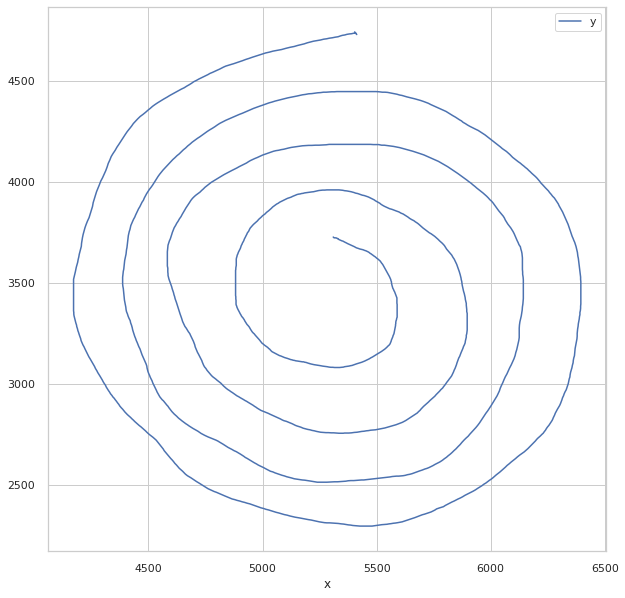

In [4]:
sample = dataset[dataset["subject_id"] == 'C01_1']
_=sample.plot(x='x', y='y', figsize=(10,10))

<AxesSubplot:>

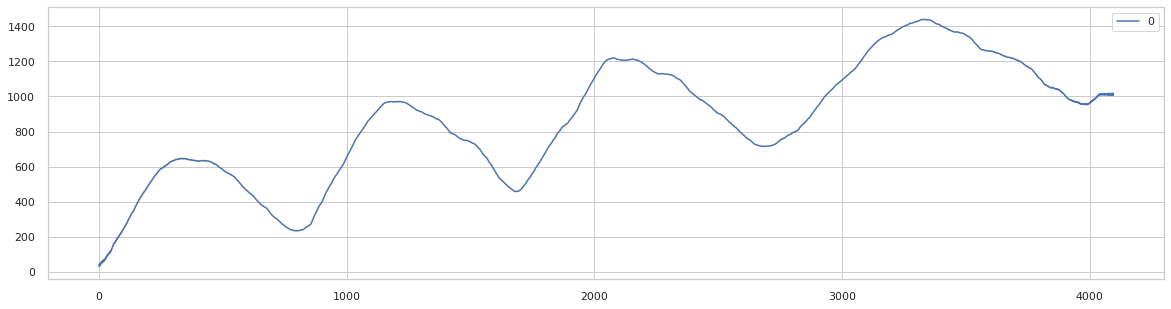

In [5]:
pd.DataFrame(abs(resample(extract_radio(sample),4196))[50:-50]).plot(figsize=(20,5))

<AxesSubplot:>

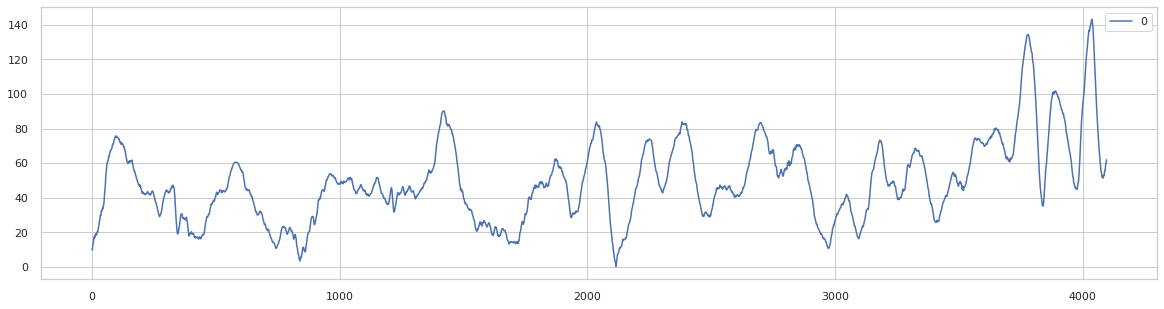

In [6]:
pd.DataFrame(abs(resample(extract_residues(sample,  c=coefficients),4196))[50:-50]).plot(figsize=(20,5))

In [7]:
pd.DataFrame(abs(resample(extract_residues(sample,  c=coefficients),5096))[50:-50]).index

RangeIndex(start=0, stop=4996, step=1)

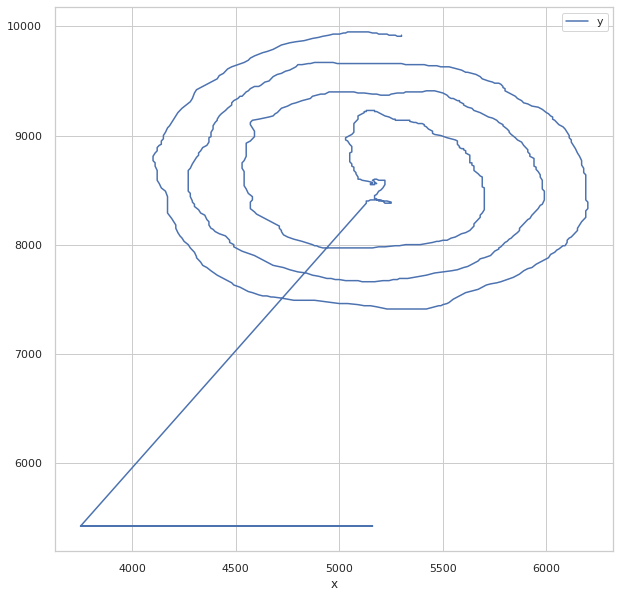

In [8]:
sample = dataset[dataset["subject_id"] == 'T012_2']
_=sample.plot(x='x', y='y', figsize=(10,10))

<AxesSubplot:>

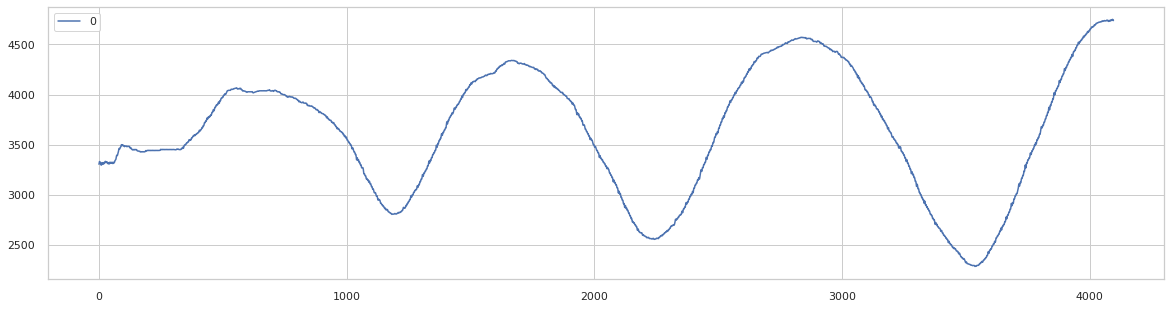

In [9]:
pd.DataFrame(abs(resample(extract_radio(sample),4196))[50:-50]).plot(figsize=(20,5))

<AxesSubplot:>

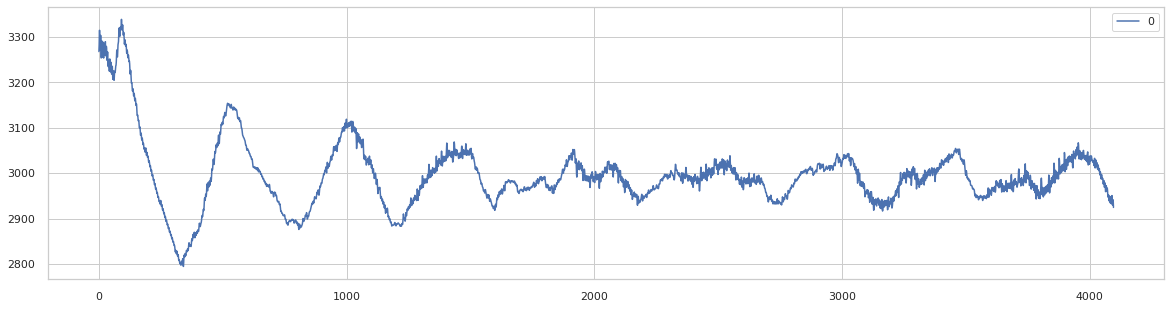

In [10]:
pd.DataFrame(abs(resample(extract_residues(sample,  c=coefficients),4196))[50:-50]).plot(figsize=(20,5))

Loading labels based on clinic, residues and features extracted from residues DCT.


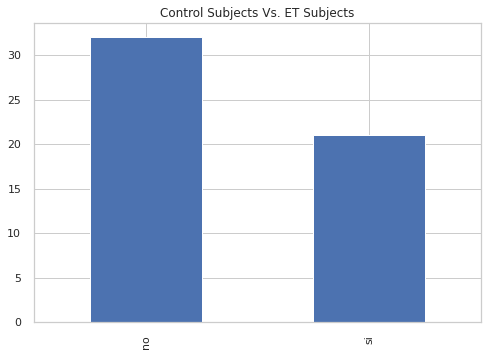

In [11]:
#Loading labels based on clinic, residues and features from residues.
labels = metadf['temblor']
labels.name = 'labels'
labels.index.name = 'labels'
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects')

Loading residues and features extracted from residues

In [12]:
rd = dataset.groupby('subject_id').apply(extract_residues, c=coefficients).apply(resample, num=4196)
rd_rd = pd.DataFrame(rd.tolist(), index=rd.index).iloc[:,50:-50].T.reset_index(drop=True).T
rd_fe = rd_rd.apply(extract_features_of, axis='columns')
rd_features = pd.DataFrame(rd_fe.tolist(), index=rd_fe.index)
rd_features.columns = properties.features_names
rd_features.sample(5)

,mean_abs_val(L),np.var(L),root_mean_square(L),log_detector(L),wl(L),np.nanstd(L),diff_abs_std(L),higuchi(L),mfl(L),myo(L),...,mp(Pxx),tp(Pxx),meanfreq(L),medfreq(L),std_psd(Pxx),"mmnt(Pxx, order=1)","mmnt(Pxx, order=2)","mmnt(Pxx, order=3)",kurt(Pxx),skw(Pxx)
subject_id,,,,,,,,,,,,,,,,,,,,,
C07_2,3360.130956,7285.985408,1.129777e+07,4.792563e+15,5154.906378,85.357984,1.846891,1.039117,8.547704,0.000000,...,14564.859069,2.984340e+07,0.319890,1.192427e-03,2.517993e+05,0.0,6.340286e+10,4.344434e+17,828.333483,27.212591
C05_1,83.437643,1576.987097,8.538827e+03,7.042594e+06,3931.203177,39.711297,1.277208,1.065070,8.276701,0.019531,...,3152.434920,6.459339e+06,0.364685,8.885298e-04,6.162603e+04,0.0,3.797768e+09,8.007669e+15,1307.856184,34.214760
T006,3698.930744,153713.537991,1.383580e+07,1.958403e+21,32285.035003,392.063181,25.811551,1.146618,10.382359,0.000000,...,307277.038365,6.296107e+08,0.507699,4.177193e-06,7.046112e+06,0.0,4.964770e+13,1.122268e+22,1068.448487,32.081004
T007,383.829334,10447.338843,1.576192e+05,7.493965e+11,16650.182232,102.212225,13.852451,1.257217,9.720176,0.002930,...,20884.480187,4.279230e+07,0.321802,1.981016e-09,3.619710e+05,0.0,1.310230e+11,1.610786e+18,1318.477041,33.963822
T005,1768.395136,11936.717670,3.139158e+06,1.734353e+15,20451.233811,109.255287,9.307534,1.059814,9.925798,0.000000,...,23861.784079,4.889280e+07,0.947903,2.676346e-01,3.836862e+05,0.0,1.472151e+11,1.587117e+18,892.117222,28.098316


### Extracted features. 

#### Temporal features

| Temporal Features| Descriptor | Funtion |
| --- | --- | --- |
| Sample Entropy (SENT) | m=3, r=2 |  **pending** |
| Mean absolute value (MAV) | $$\frac{1}{N}\sum_{i=1}^{N}{|X_{i}|} $$ | mean_abs_val(L) |
| Variance (VAR) | $$\frac{1}{N-1}\sum_{i=1}^{N}{|X_{i} - µ |^{2}} $$ |  np.var(L) |
| Root Mean Square (RMS) |  $$ \sum_{i=1}^{N}{\frac{1}{N}X_{i}^{2}} $$  |  root_mean_square(L) |
| Log Detector (LOG) | $$ \exp^{ \frac{1}{N} \sum_{i=1}^{N}{\log{|X_{i}|}} } $$ | log_detector(L) |
| Waveform length (WL) | $$ \sum_{i=1}^{N-1}{|X_{i+1} - X_{i}|}$$ | wl(L) |
| Standard deviation (STD) | $$$$ | np.nanstd(L) |
| Difference Absolute standard deviation (ACC) |||
| Fractal Dimension (FD) |||
| Maximum Fractal Length (MFL) |||
| Myopulse percentage rate (MYO) |||
| Integrated EMG (IEMG) |||
| Simple Square EMG (SSI) |||
| Zero Crossing (ZC) |||
| Slope sign change (SSC) |||
| Wilson Amplitude (WAMP) | $\sum_{i=1}^{N-1}{|X_{i}-X_{i+1}| > \epsilon}$ where $\epsilon$ is the mean of the signal | wamp(L) |
| Autoregressive coefficients (AR, 4 coefficients) |||



#### Frequency features

| Frequency Features| Descriptor | Funtion |
| --- | --- | --- |
 | | |





The paper deeps dive on several number of features tested and experimentally obtaining the best performance using the top 5-predictor rank features. The 5 characteristics selected in residue method are the following, sorted according to their importance

1. Mean frecuency (MNF, meanfreq(L)
2. Wilson amplitude (WAMP), wamp(L)
3. Mean absolute value (MAV), mean_abs_val(L)
4. Maximum fractal length (MFL), mfl(L)
5. Fractal dimension (FD), higuchi(L)



In [13]:
rd_features.columns

Index(['mean_abs_val(L)', 'np.var(L)', 'root_mean_square(L)',
       'log_detector(L)', 'wl(L)', 'np.nanstd(L)', 'diff_abs_std(L)',
       'higuchi(L)', 'mfl(L)', 'myo(L)', 'iemg(L)', 'ssi(L)', 'zc(L)',
       'ssc(L)', 'wamp(L)', 'p_max(Pxx, L)', 'f_max(Pxx)', 'mp(Pxx)',
       'tp(Pxx)', 'meanfreq(L)', 'medfreq(L)', 'std_psd(Pxx)',
       'mmnt(Pxx, order=1)', 'mmnt(Pxx, order=2)', 'mmnt(Pxx, order=3)',
       'kurt(Pxx)', 'skw(Pxx)'],
      dtype='object')

See below the shape of extracted features (27), number of data points for residues and radius (4096) and total number of samples (50). In order to ensure the same number ofpoints in each sequence, we resampled all the exercises to enforce 4096 points in all of them.

In [14]:
rd_rd.shape,rd_features.shape,labels.shape

((53, 4096), (53, 27), (53,))

In [15]:
rd_rd.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
subject_id,,,,,,,,,,,,,,,,,,,,,
C107_2,2801.966221,2851.274132,2893.921117,2878.099913,2823.505811,2794.962477,2823.140151,2869.195520,2873.976955,2829.792868,...,2645.944837,2685.243168,2727.066481,2724.943964,2685.632929,2662.397144,2690.310074,2741.997183,2759.511315,2725.390838
C107_1,4028.875423,4021.602278,4054.121072,4097.263373,4103.987237,4104.408593,4135.088904,4164.951382,4166.345869,4168.663009,...,3472.156487,3439.705719,3472.788738,3506.291500,3472.153207,3444.999017,3486.904068,3513.887958,3470.796977,3450.449112
T010,52.060947,54.622587,56.716406,57.007528,54.851446,50.684921,45.830018,41.786163,39.423258,38.574648,...,143.863988,144.684657,144.519728,143.343400,141.423001,139.289391,137.497896,136.331776,135.670919,135.134258
T011_2,3024.687525,3020.876242,3015.767180,3008.495469,3001.251460,2996.499955,2993.834833,2990.599992,2985.554555,2980.781397,...,2763.778860,2767.033540,2777.385798,2783.414043,2778.818048,2770.613924,2770.763091,2781.128138,2790.587110,2788.571984
T021,27.784825,27.760515,25.593334,32.097242,27.825199,32.345278,34.028570,31.596506,38.282707,35.091924,...,486.487095,499.238653,521.109371,531.539507,553.622665,571.059697,585.258700,608.372105,615.633603,631.243008


## Features Analysis based on Pearson Correlation

As the first step we can try to visualy identify correlation between features and also with target class

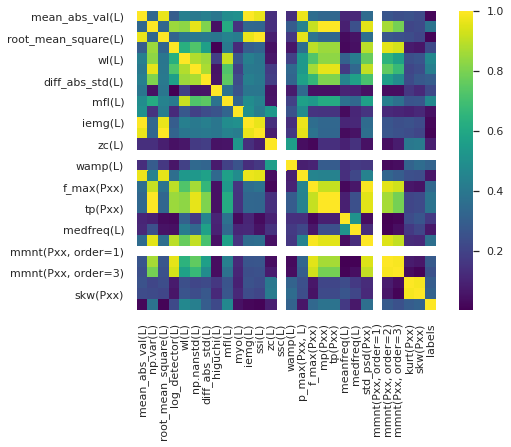

In [16]:
df=rd_features.join((labels == 'si').astype('int8'))
corrMatrix = df.corr("pearson")
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask, 0)] = True
_ = sns.heatmap(corrMatrix.abs(), square=True, cmap="viridis")

There is not strong correlation between independent variables (features) and dependent variable "labels" (target). Furthermore, some of the features are highly correlated. This can lead multicollinearity. **Multicollinearity** is the occurrence of high intercorrelations among two or more independent variables in a multiple regression model. Multicollinearity can lead to skewed or misleading results when a researcher or analyst attempts to determine how well each independent variable can be used most effectively to predict or understand the dependent variable in a statistical model. Let's analyce the most correlated variables with target.

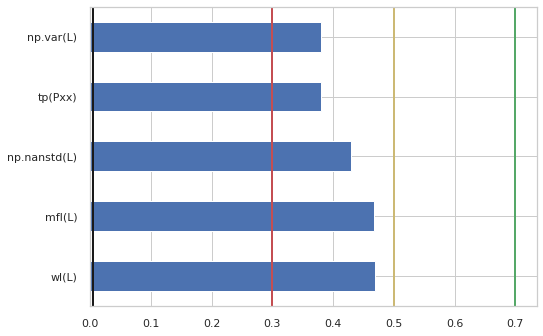

In [17]:
top5 = corrMatrix.abs().labels.sort_values(ascending=False)[0:6]
top5[1:6].plot.barh()
plt.plot([0.7, 0.7],[-1.0,10.0], 'g-', lw=2)
plt.plot([0.5, 0.5],[-1.0,10.0], 'y-', lw=2)
plt.plot([0.3, 0.3],[-1.0,10.0], 'r-', lw=2)
_=plt.plot([0.005, 0.005],[-1.0,10.0], 'k-', lw=2)

Pearson correlation coefficients whose magnitude are between 0.5 and 0.7 indicate variables which can be considered moderately correlated. Correlation coefficients whose magnitude are between 0.3 and 0.5 indicate variables which have a low correlation. We did not fing strongly correlated features with target variables.

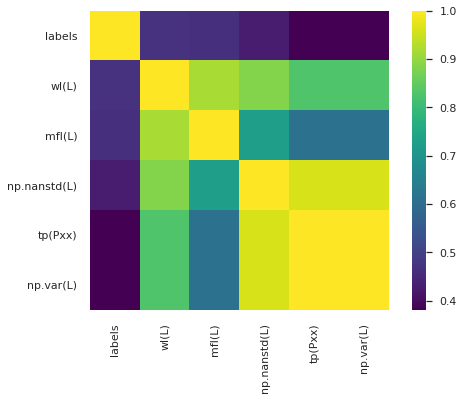

In [18]:
_=sns.heatmap(corrMatrix[top5.index].loc[top5.index], square=True, cmap="viridis")

In [19]:
r = dataset.groupby('subject_id').apply(extract_radio).apply(resample, num=4196)
r_df = pd.DataFrame(r.tolist(), index=r.index).iloc[:,50:-50].T.reset_index(drop=True).T
r_fe = r_df.apply(extract_features_of, axis='columns')
r_features = pd.DataFrame(r_fe.tolist(), index=r_fe.index)
r_features.columns = properties.features_names
r_features.head()

,mean_abs_val(L),np.var(L),root_mean_square(L),log_detector(L),wl(L),np.nanstd(L),diff_abs_std(L),higuchi(L),mfl(L),myo(L),...,mp(Pxx),tp(Pxx),meanfreq(L),medfreq(L),std_psd(Pxx),"mmnt(Pxx, order=1)","mmnt(Pxx, order=2)","mmnt(Pxx, order=3)",kurt(Pxx),skw(Pxx)
subject_id,,,,,,,,,,,,,,,,,,,,,
C01_1,861.910042,110601.867503,853490.787846,5.960710e+16,5588.629415,332.568591,1.743259,1.090503,8.628489,0.0,...,221095.778084,4.530252e+08,0.255571,6.807539e-07,5.066859e+06,0.0,2.567306e+13,4.406309e+21,1285.553770,33.873380
C01_2,810.043456,93408.251082,749578.650958,2.206810e+16,4133.633301,305.627635,1.516266,1.277092,8.326912,0.0,...,186725.327687,3.826002e+08,0.318667,1.410239e-04,4.457246e+06,0.0,1.986705e+13,3.240586e+21,1462.492390,36.595154
C02_1,863.688772,60192.788652,806151.083386,1.050405e+16,4013.007356,245.342187,1.483161,1.248445,8.297296,0.0,...,120326.823972,2.465497e+08,0.280882,7.635608e-10,2.921691e+06,0.0,8.536278e+12,1.026392e+21,1784.977869,41.153842
C02_2,845.589382,97130.862431,812152.265586,3.606844e+16,5723.806837,311.658246,1.982142,1.162269,8.652389,0.0,...,194166.916797,3.978480e+08,0.301075,5.157453e-04,4.296293e+06,0.0,1.845814e+13,2.287262e+21,880.602898,28.842587
C03_1,855.098952,62931.246835,794125.464878,1.102861e+16,3624.773968,250.861011,1.430809,1.348303,8.195547,0.0,...,125801.067367,2.577664e+08,0.279205,4.725305e-06,2.923260e+06,0.0,8.545448e+12,9.618650e+20,1597.735244,38.504535


<AxesSubplot:>

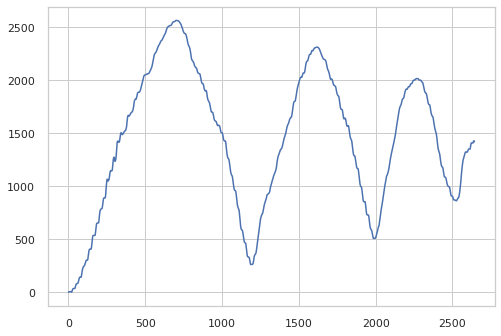

In [20]:
r = dataset.groupby('subject_id').apply(extract_radio)
r_df = pd.DataFrame(r.tolist(), index=r.index)
r_df.loc["T001"].plot()

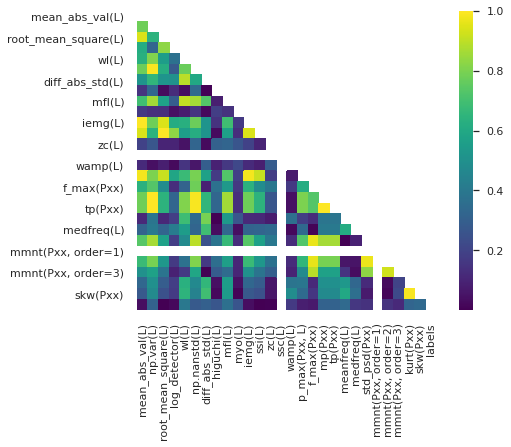

In [21]:
df=r_features.join((labels == 'si').astype('int8'))
corrMatrix = df.corr("pearson")
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
_ = sns.heatmap(corrMatrix.abs(), mask=mask, square=True, cmap="viridis")

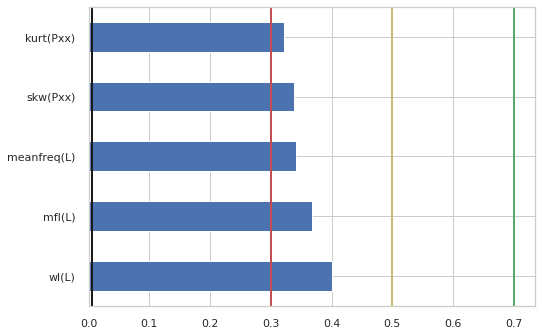

In [22]:
top5 = corrMatrix.abs().labels.sort_values(ascending=False)[0:6]
top5[1:6].plot.barh()
plt.plot([0.7, 0.7],[-1.0,10.0], 'g-', lw=2)
plt.plot([0.5, 0.5],[-1.0,10.0], 'y-', lw=2)
plt.plot([0.3, 0.3],[-1.0,10.0], 'r-', lw=2)
_=plt.plot([0.005, 0.005],[-1.0,10.0], 'k-', lw=2)

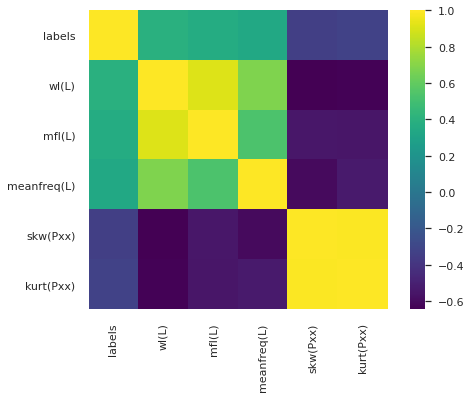

In [23]:
_=sns.heatmap(corrMatrix[top5.index].loc[top5.index], square=True, cmap="viridis")

## Relief-Based Feature Selection
For details on the algorithmic differences between the various Relief algorithms, please refer to [this research paper](https://arxiv.org/abs/1711.08477)

After applying ReliefF we obtained the scoring of the importance for each variable according to the ReliefF scoring process.

### Residue method:

#### ReliefF

1. Difference Absolute standard deviation (diff_abs_std)
2. Maximum fractal length (mfl)
3. Fractal dimension (higuchi)
4. Waveform length (wl) 
5. skewness (SKW)

#### RFE and ReliefF

1. Difference Absolute standard deviation (diff_abs_std)
3. Fractal dimension (higuchi)
2. Maximum fractal length (mfl)
4. Mean Frequency (meanfreq) 
5. skewness (SKW)



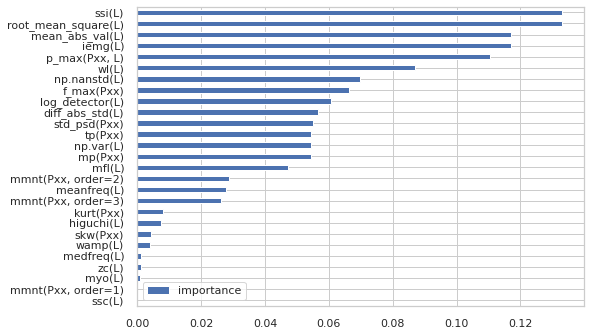

In [24]:
from skrebate import ReliefF

fltr = ReliefF(n_features_to_select=5)
fs = fltr.fit(rd_features.values, labels.values)
_=pd.DataFrame(fs.feature_importances_, rd_features.columns, columns=["importance"]).abs().sort_values("importance", ascending=True).plot.barh()

In [25]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = make_pipeline(ReliefF(n_features_to_select=5, n_neighbors=100),
                    RandomForestClassifier(50))

print(np.mean(cross_val_score(clf, rd_features.values, labels.values)))

0.6745454545454544


### Radius method:

#### ReliefF

1. Zero crossing (zc)
2. Fractal dimension (higuchi)
3. Difference Absolute standard deviation (diff_abs_std)
4. Maximum Fractal Length (mfl) 
5. Kurtosis (kurt)

#### RFE and ReliefF

1. Mean absolute value (mean_abs_val), 
2. Difference Absolute standard deviation (diff_abs_std)
3. Fractal dimension (higuchi)
4. Maximum Fractal Length (mflL)
5. Zero Crossing (zc)


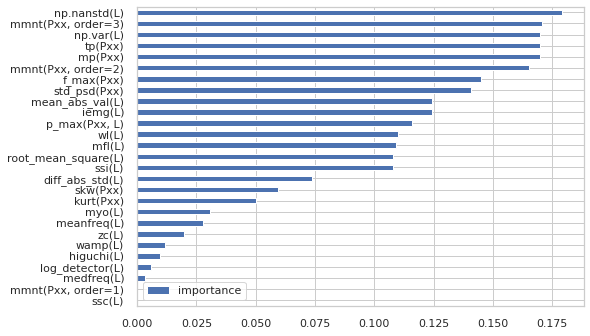

In [26]:
fltr = ReliefF(n_features_to_select=5)
fs = fltr.fit(r_features.values, labels.values)
_=pd.DataFrame(fs.feature_importances_, r_features.columns, columns=["importance"]).abs().sort_values("importance", ascending=True).plot.barh()

In [27]:
clf = make_pipeline(ReliefF(n_features_to_select=5, n_neighbors=100),
                    RandomForestClassifier(15))

print(np.mean(cross_val_score(clf, r_features.values, labels.values)))

0.5254545454545455


## Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

In [28]:
from sklearn.feature_selection import RFE
print(RFE.__doc__)

Feature ranking with recursive feature elimination.

    Given an external estimator that assigns weights to features (e.g., the
    coefficients of a linear model), the goal of recursive feature elimination
    (RFE) is to select features by recursively considering smaller and smaller
    sets of features. First, the estimator is trained on the initial set of
    features and the importance of each feature is obtained either through
    any specific attribute or callable.
    Then, the least important features are pruned from current set of features.
    That procedure is recursively repeated on the pruned set until the desired
    number of features to select is eventually reached.

    Read more in the :ref:`User Guide <rfe>`.

    Parameters
    ----------
    estimator : ``Estimator`` instance
        A supervised learning estimator with a ``fit`` method that provides
        information about feature importance
        (e.g. `coef_`, `feature_importances_`).

    n_features_to_se

In [29]:
selector = RFE(ReliefF(), n_features_to_select=5)
selector_rd = selector.fit(rd_features.values, labels.values)
idx_rd = np.where(selector_rd.ranking_ == 1)
rd_features.columns[idx_rd]

Index(['mean_abs_val(L)', 'root_mean_square(L)', 'iemg(L)', 'ssi(L)',
       'p_max(Pxx, L)'],
      dtype='object')

The density plots on the diagonal make it easier to compare distributions between the clinic (ET) and controls (CT) subjects than stacked bars. Unfortunately, even though we are working with more important variables **there are not** strong differences between ET and CT

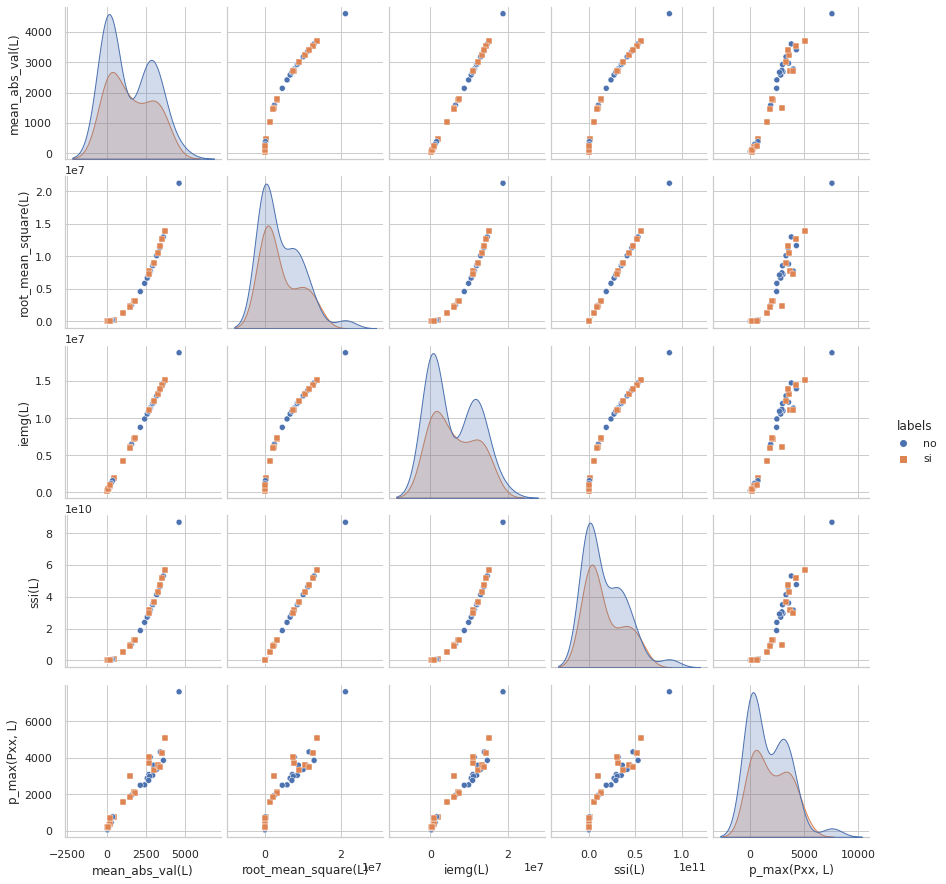

In [30]:
_=sns.pairplot(rd_features[rd_features.columns[idx_rd]].join(labels), hue="labels", markers=["o", "s"])

In [31]:
clf = make_pipeline(selector_rd,
                    RandomForestClassifier(n_estimators=15))

print(np.mean(cross_val_score(clf, rd_features.values, labels.values)))

0.5945454545454545


In [32]:
selector_r = selector.fit(r_features.values, labels.values)
idx_r = np.where(selector_r.ranking_ == 1)
r_features.columns[idx_r]

Index(['np.var(L)', 'np.nanstd(L)', 'mp(Pxx)', 'tp(Pxx)', 'std_psd(Pxx)'], dtype='object')

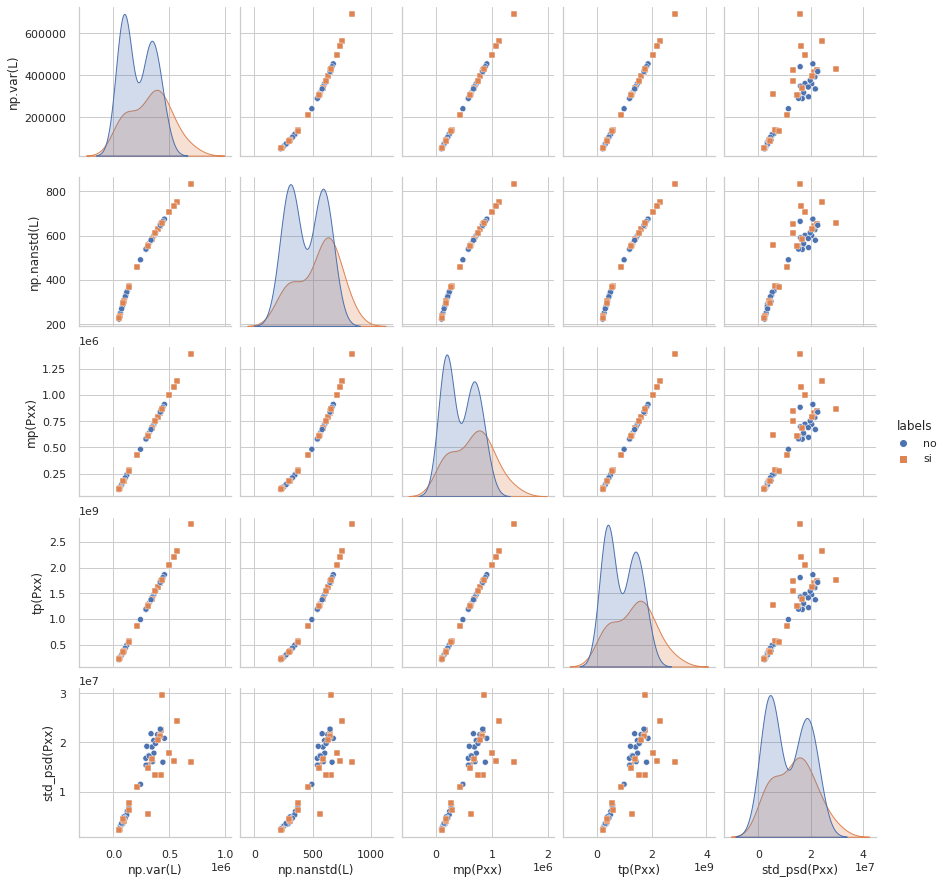

In [33]:
_=sns.pairplot(r_features[r_features.columns[idx_r]].join(labels), hue="labels", markers=["o", "s"])

In [34]:
clf = make_pipeline(selector_r,
                    RandomForestClassifier(n_estimators=15))

print(np.mean(cross_val_score(clf, r_features.values, labels.values)))

0.5818181818181818


In [35]:
r_features.shape

(53, 27)

## Classification system

To evaluate the performance of these algorithms we implemented the leave-one-out technique. Although all the drawing samples have been done with a template and the same pen tablet, the number of drawing points acquired was different for each sample. Linear Discriminant analysis (LDA), k-nearest neighbors (k- NN) and support vector machine (SVM) with radial basis kernel have been used as classification algorithm to discriminate between ET and control subjects. To

In [36]:
#adding local modules
import sys
from os import path

module_path = path.abspath(path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from analysis.clf_loo import analysis_loo

In [37]:
y = (labels == 'si').astype('int8')
X=rd_features
analysis_loo(X, y) 

train score svm
0.812409288824383
test score svm
0.7547169811320755
train score Random forest
0.9934687953555879
test score Random forest
0.6792452830188679
train score Knn
0.9956458635703919
test score Knn
0.660377358490566
train score LDA
0.9898403483309145
test score LDA
0.660377358490566


In [38]:
X=r_features
analysis_loo(X, y) 

train score svm
0.868287373004354
test score svm
0.7358490566037735
train score Random forest
0.9912917271407837
test score Random forest
0.6415094339622641
train score Knn
0.9887518142235123
test score Knn
0.6415094339622641
train score LDA
0.9909288824383164
test score LDA
0.6226415094339622
